# CNNGeometric demo notebook
This notebook shows how to run a trained model on a given image pair

## Imports

In [1]:
from __future__ import print_function, division
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_willow
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize,Compose
from collections import OrderedDict
# import cv2 as cv

warnings.filterwarnings('ignore')

## Parameters

In [8]:
# feature_extraction_cnn = 'resnet101'
feature_extraction_cnn = 'vgg'

model_hom_path = ''

if feature_extraction_cnn=='vgg':
    # model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss.pth.tar'
    # model_tps_path = 'trained_models/best_pascal_checkpoint_adam_tps_grid_loss.pth.tar'
    # model_hom_path = 'trained_models/best_pascal_checkpoint_adam_hom_grid_loss_PAMI.pth.tar'
    model_aff_path = 'trained_models/best_streetview_checkpoint_adam_affine_grid_loss.pth.tar'
    model_tps_path = 'trained_models/best_streetview_checkpoint_adam_tps_grid_loss.pth.tar'
    model_hom_path = 'trained_models/best_streetview_checkpoint_adam_hom_grid_loss_PAMI.pth.tar'
elif feature_extraction_cnn=='resnet101':
    # model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss_resnet_random.pth.tar'
    model_aff_path = 'trained_models/checkpoint_adam/best_checkpoint_adam_affine_grid_lossresnet101.pth.tar'
    # model_tps_path = 'trained_models/best_pascal_checkpoint_adam_tps_grid_loss_resnet_random.pth.tar'   
    model_hom_path = 'trained_models/checkpoint_adam/best_checkpoint_adam_hom_grid_lossresnet101.pth.tar'   



#source_image_path='datasets/PF-dataset/duck(S)/060_0036.png'
#target_image_path='datasets/PF-dataset/duck(S)/060_0013.png'


source_image_path='datasets/testDataset/street2.jpg'
target_image_path='datasets/testDataset/street1.jpg'

## Load models

In [3]:
use_cuda = torch.cuda.is_available()
do_aff = not model_aff_path==''
do_tps = not model_tps_path==''
do_hom = not model_hom_path==''

# Create model
print('Creating CNN model...')
if do_aff:
    model_aff = CNNGeometric(use_cuda=use_cuda,output_dim=6,feature_extraction_cnn=feature_extraction_cnn)
if do_tps:
    model_tps = CNNGeometric(use_cuda=use_cuda,output_dim=18,feature_extraction_cnn=feature_extraction_cnn)
if do_hom:
    model_hom = CNNGeometric(use_cuda=use_cuda,output_dim=8,feature_extraction_cnn=feature_extraction_cnn)
    
# Load trained weights
print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])
if do_tps:
    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps.load_state_dict(checkpoint['state_dict'])
if do_hom:
    checkpoint = torch.load(model_hom_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_hom.load_state_dict(checkpoint['state_dict'])

Creating CNN model...
Loading trained model weights...


## Create image transformers

In [4]:
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)
homTnf = GeometricTnf(geometric_model='hom', use_cuda=use_cuda)

## Load and preprocess images

In [5]:
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 
normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

In [9]:
source_image = io.imread(source_image_path)
target_image = io.imread(target_image_path)

source_image_var = preprocess_image(source_image)
target_image_var = preprocess_image(target_image)

if use_cuda:
    source_image_var = source_image_var.cuda()
    target_image_var = target_image_var.cuda()

batch = {'source_image': source_image_var, 'target_image':target_image_var}

resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

***** im size ****
torch.Size([1, 3, 240, 240])
tensor([[[[0.4850, 0.4850, 0.4850,  ..., 0.4850, 0.4850, 0.4850],
          [0.4850, 0.4850, 0.4850,  ..., 0.4850, 0.4850, 0.4850],
          [0.4850, 0.4850, 0.4850,  ..., 0.4850, 0.4850, 0.4850],
          ...,
          [0.4850, 0.4850, 0.4850,  ..., 0.4850, 0.4850, 0.4850],
          [0.4850, 0.4850, 0.4850,  ..., 0.4850, 0.4850, 0.4850],
          [0.4850, 0.4850, 0.4850,  ..., 0.4850, 0.4850, 0.4850]],

         [[0.4560, 0.4560, 0.4560,  ..., 0.4560, 0.4560, 0.4560],
          [0.4560, 0.4560, 0.4560,  ..., 0.4560, 0.4560, 0.4560],
          [0.4560, 0.4560, 0.4560,  ..., 0.4560, 0.4560, 0.4560],
          ...,
          [0.4560, 0.4560, 0.4560,  ..., 0.4560, 0.4560, 0.4560],
          [0.4560, 0.4560, 0.4560,  ..., 0.4560, 0.4560, 0.4560],
          [0.4560, 0.4560, 0.4560,  ..., 0.4560, 0.4560, 0.4560]],

         [[0.4060, 0.4060, 0.4060,  ..., 0.4060, 0.4060, 0.4060],
          [0.4060, 0.4060, 0.4060,  ..., 0.4060, 0.4060, 0.4

## Evaluate model

In [10]:
if do_aff:
    model_aff.eval()
if do_tps:
    model_tps.eval()
if do_hom:
    model_hom.eval()

# Evaluate models
if do_aff:
    theta_aff=model_aff(batch)
    print(theta_aff.view(-1,2,3))
    warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))

if do_tps:
    theta_tps=model_tps(batch)
    print(theta_tps)
    warped_image_tps = tpsTnf(batch['source_image'],theta_tps)

if do_aff and do_tps:
    theta_aff_tps=model_tps({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
    warped_image_aff_tps = tpsTnf(warped_image_aff,theta_aff_tps)

if do_hom:
    theta_hom=model_hom(batch)
    print(theta_hom)
    warped_image_hom = homTnf(batch['source_image'],theta_hom)

tensor([[[ 0.9740,  0.1521, -0.1368],
         [-0.0997,  0.9952,  0.0191]]], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor([[-1.3429, -1.2165, -1.3356, -0.4374, -0.4988, -0.5148,  1.2783,  1.0785,
          1.2747, -0.6860,  0.0675,  0.8576, -1.0571, -0.1289,  0.9688, -1.1584,
         -0.0914,  1.2247]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.2762, -1.2553,  0.8751,  0.9416, -0.7226,  0.6625, -1.1873,  1.1643]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Homografy Matrix
torch.Size([1, 9])
tensor([[ 1.1332,  0.0198, -0.4599,  0.0134,  0.8718, -0.0281, -0.2586, -0.0053,
          1.0000]], device='cuda:0', grad_fn=<SqueezeBackward1>)


## Process result

In [11]:
# Un-normalize images and convert to numpy
if do_aff:
    warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_tps:
    warped_image_tps_np = normalize_image(resizeTgt(warped_image_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_aff and do_tps:
    warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_hom:
    warped_image_hom_np = normalize_image(resizeTgt(warped_image_hom),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

***** im size ****
torch.Size([1, 3, 480, 640])
***** im size ****
torch.Size([1, 3, 480, 640])
***** im size ****
torch.Size([1, 3, 480, 640])
***** im size ****
torch.Size([1, 3, 480, 640])



source_image_var = preprocess_image(warped_image_hom_np)

if use_cuda:
    source_image_var = source_image_var.cuda()
    target_image_var = target_image_var.cuda()

batch = {'source_image': source_image_var, 'target_image':target_image_var}

# resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

## Display

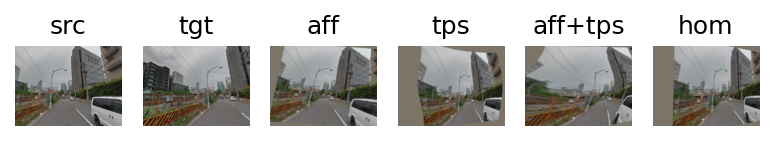

In [12]:
N_subplots = 2+int(do_aff)+int(do_tps)+int(do_aff and do_tps)+int(do_hom)
fig, axs = plt.subplots(1,N_subplots)
axs[0].imshow(source_image)
axs[0].set_title('src')
axs[1].imshow(target_image)
axs[1].set_title('tgt')
subplot_idx = 2
if do_aff:
    axs[subplot_idx].imshow(warped_image_aff_np)
    axs[subplot_idx].set_title('aff')
    subplot_idx +=1 
if do_tps:
    axs[subplot_idx].imshow(warped_image_tps_np)
    axs[subplot_idx].set_title('tps')
    subplot_idx +=1 
if do_aff and do_tps:
    axs[subplot_idx].imshow(warped_image_aff_tps_np)
    axs[subplot_idx].set_title('aff+tps')
    subplot_idx +=1 
if do_hom:
    axs[subplot_idx].imshow(warped_image_hom_np)
    axs[subplot_idx].set_title('hom')

for i in range(N_subplots):
    axs[i].axis('off')

fig.set_dpi(150)
plt.show()

In [60]:
warped_image_aff_np = warped_image_aff_np * 255
io.imsave("results/resultAff.jpg",warped_image_aff_np)

warped_image_tps_np = warped_image_tps_np * 255
io.imsave("results/resultTps.jpg",warped_image_tps_np)

warped_image_aff_tps_np = warped_image_aff_tps_np * 255
io.imsave("results/resultAff-Tps.jpg",warped_image_aff_tps_np)

warped_image_hom_np = warped_image_hom_np * 255
io.imsave("results/resultHom.jpg",warped_image_hom_np)

Lossy conversion from float32 to uint8. Range [9.008465766906738, 252.6087188720703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [9.22196102142334, 254.92288208007812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.658336639404297, 252.32113647460938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [9.20762825012207, 254.3977813720703]. Convert image to uint8 prior to saving to suppress this warning.
